In [3]:
# Install dependencies (Colab only)
!pip install pyspark==3.5.0 delta-spark==3.1.0 -q

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

# Build SparkSession with Delta support
builder = (
    SparkSession.builder.appName("DeltaLakeProject")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Create sample ride-hailing dataset
data = [
    (1, "John", "Sedan", 15.0, "2025-08-01"),
    (2, "Sara", "SUV", 25.0, "2025-08-02"),
    (3, "Mike", "Sedan", 18.0, "2025-08-03"),
    (4, "Nina", "Hatchback", 12.0, "2025-08-04"),
]
columns = ["ride_id", "driver_name", "vehicle_type", "fare_amount", "ride_date"]

df = spark.createDataFrame(data, columns)

# Save as Delta
df.write.format("delta").mode("overwrite").save("/tmp/rides_delta")

print("Environment ready & dataset created")


Environment ready & dataset created


In [2]:
# Managed table
spark.sql("DROP TABLE IF EXISTS rides_managed")
spark.sql("CREATE TABLE rides_managed USING DELTA LOCATION '/tmp/rides_delta'")

# Unmanaged table
spark.sql("DROP TABLE IF EXISTS rides_unmanaged")
spark.sql("CREATE TABLE rides_unmanaged USING DELTA LOCATION '/tmp/rides_delta'")

print(" Managed & unmanaged tables created")


 Managed & unmanaged tables created


In [4]:
from delta.tables import DeltaTable
from pyspark.sql.functions import col

deltaTable = DeltaTable.forPath(spark, "/tmp/rides_delta")

# Update: Increase Sedan fares by 5
deltaTable.update(
    condition=col("vehicle_type") == "Sedan",
    set={"fare_amount": col("fare_amount") + 5}
)

# Delete: Remove fares less than 13
deltaTable.delete(condition=col("fare_amount") < 13)

# Merge new data
new_data = [
    (3, "Mike", "Sedan", 30.0, "2025-08-03"),  # Updated
    (5, "Alex", "SUV", 28.0, "2025-08-05")     # New
]
new_df = spark.createDataFrame(new_data, columns)

deltaTable.alias("old").merge(
    new_df.alias("new"),
    "old.ride_id = new.ride_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

print(" CRUD operations completed")


 CRUD operations completed


In [5]:
# Show history
spark.sql("DESCRIBE HISTORY delta.`/tmp/rides_delta`").show(truncate=False)

# Read version 0
print("Version 0:")
spark.read.format("delta").option("versionAsOf", 0).load("/tmp/rides_delta").show()

# Read latest
print("Latest Version:")
spark.read.format("delta").load("/tmp/rides_delta").show()


+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|versio

In [6]:
# Save partitioned by vehicle_type
df.write.format("delta").mode("overwrite").partitionBy("vehicle_type").save("/tmp/rides_partitioned")

print(" Partitioned data saved")


 Partitioned data saved


In [7]:
# New batch
new_batch = [
    (6, "Emma", "Sedan", 20.0, "2025-08-06"),
    (7, "David", "Hatchback", 15.0, "2025-08-07")
]
batch_df = spark.createDataFrame(new_batch, columns)

batch_df.write.format("delta").mode("append").save("/tmp/rides_delta")

print(" Incremental load appended")


 Incremental load appended


In [8]:
stream_df = (
    spark.readStream.format("delta")
    .load("/tmp/rides_delta")
)

query = (
    stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Let it run for ~20 seconds, then stop in Colab manually


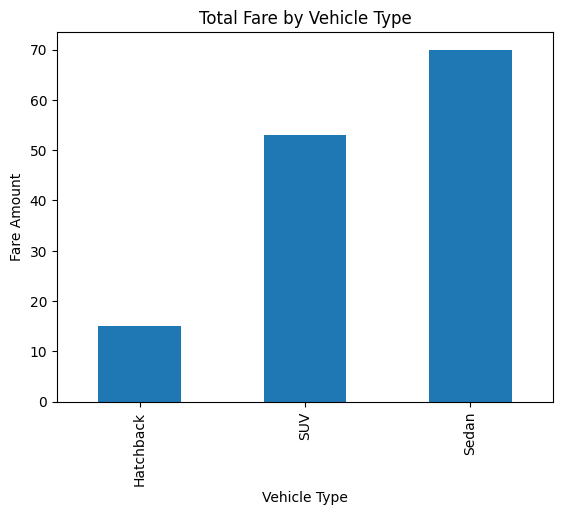

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = spark.read.format("delta").load("/tmp/rides_delta").toPandas()
summary = pdf.groupby("vehicle_type")["fare_amount"].sum()

summary.plot(kind="bar", title="Total Fare by Vehicle Type", ylabel="Fare Amount", xlabel="Vehicle Type")
plt.show()


In [10]:
# Save as Parquet
df.write.mode("overwrite").parquet("/tmp/rides_parquet")

# Convert to Delta
spark.read.format("parquet").load("/tmp/rides_parquet") \
    .write.format("delta").mode("overwrite").save("/tmp/rides_from_parquet")

print("Parquet converted to Delta")


Parquet converted to Delta


In [11]:
spark.sql("""
CREATE TABLE rides_with_constraint (
    ride_id INT,
    driver_name STRING,
    vehicle_type STRING,
    fare_amount DOUBLE,
    ride_date STRING
) USING DELTA
TBLPROPERTIES ('delta.constraints.fare_check' = 'fare_amount >= 0')
""")
print(" Table with constraint created")


 Table with constraint created


In [12]:
spark.sql("DROP TABLE IF EXISTS rides_unmanaged")

import os
print("Files still exist:", os.path.exists("/tmp/rides_delta"))


Files still exist: True


In [13]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
spark.sql("VACUUM delta.`/tmp/rides_delta` RETAIN 0 HOURS")
print(" Vacuum completed")


 Vacuum completed


In [14]:
spark.sql("OPTIMIZE delta.`/tmp/rides_delta` ZORDER BY (vehicle_type)")
print(" Optimize & Z-Order completed")


 Optimize & Z-Order completed


In [15]:
new_schema_data = [
    (8, "Sam", "Sedan", 22.0, "2025-08-08", "Premium"),
]
new_schema_cols = ["ride_id", "driver_name", "vehicle_type", "fare_amount", "ride_date", "service_type"]
new_schema_df = spark.createDataFrame(new_schema_data, new_schema_cols)

new_schema_df.write.format("delta").mode("append").option("mergeSchema", "true").save("/tmp/rides_delta")
print(" Schema evolved with new column")


 Schema evolved with new column


In [16]:
spark.stop()
print(" Spark session stopped")


 Spark session stopped
